# 6 Regression Discontinuity

## 6.2.2 Continuity

In [2]:
# rdd_simulate1

In [73]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

np.random.seed(12282020)

n = 1000
df = pd.DataFrame(index = range(n))
random_draws = np.random.normal(50, 25, n)
df['x'] = (random_draws > 0) * random_draws
df = df[df.x < 100]

df['D'] = 1 * (df.x > 50)

df['y1'] = 25 + 0*df.D + 1.5 * df.x + np.random.normal(0, 20, len(df))
df['y2'] = 25 + 40*df.D + 1.5 * df.x + np.random.normal(0, 20, len(df))
#print('"Counterfactual Potential Outcomes')


#p.ggplot(dat, p.aes(x='x', y='y1', color = 'factor(D)')) +    
#p.geom_point(alpha = 0.5) +    p.geom_vline(xintercept = 50, colour = "grey") +
#p.stat_smooth(method = "lm", se = 'F') +    p.labs(x = "Test score (X)", y = "Potential Outcome (Y1)")

In [110]:
def helper(D, ax, col = 'y1'):
    global df
    
    temp = df[df.D == D]
    marker = 'o'
    color = 'lightgray'
    
    if D > 0:
        marker = '^'
        color = 'black'
    ax.scatter(temp.x, temp[col], color = color, alpha = .95, marker = marker, edgecolor = 'black', s = 12)
    
    del temp
    
def reg_helper(D, col = 'y1'):
    global df
    temp = df[df.D == D]
    y = temp[col]
    temp['const'] = 1
    X = temp[['const', 'x']]
    

    model = sm.OLS(y, X).fit()
    
    return model.params

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


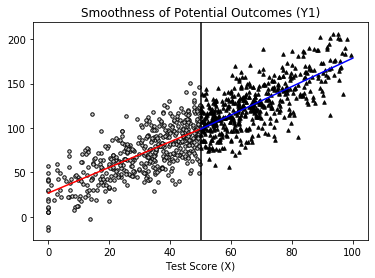

In [111]:
fig, ax = plt.subplots()
helper(0,ax)
helper(1,ax)
ax.axvline(50, ymin = 0, ymax = 1, color = 'black' )

ax.set_title("Smoothness of Potential Outcomes (Y1)")
ax.set_xlabel("Test Score (X)")

params = reg_helper(D = 0)
y = np.linspace(np.dot(np.array([1,0]),params), np.dot(np.array([1,50]),params),2)
ax.plot(np.linspace(0,50,2), y, color = 'red')

params = reg_helper(D = 1)
y = np.linspace(np.dot(np.array([1,50]),params), np.dot(np.array([1,100]),params),2)
ax.plot(np.linspace(50,100,2), y, color = 'blue')

fig.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


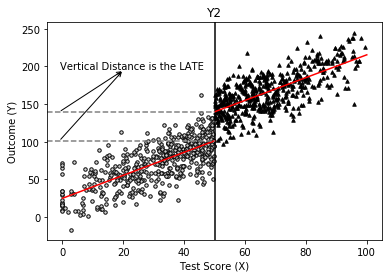

In [147]:
fig, ax = plt.subplots()
helper(0,ax, col = 'y2')
helper(1,ax, col = 'y2')
ax.axvline(50, ymin = 0, ymax = 1, color = 'black' )

ax.set_title("Smoothness of Potential Outcomes (Y1)")
ax.set_xlabel("Test Score (X)")

params = reg_helper(D = 0, col = 'y2')
y = np.linspace(np.dot(np.array([1,0]),params), np.dot(np.array([1,50]),params),2)
y1 = y[1]
ax.plot(np.linspace(0,50,2), y, color = 'red')

params = reg_helper(D = 1, col = 'y2')
y = np.linspace(np.dot(np.array([1,50]),params), np.dot(np.array([1,100]),params),2)
y2 = y[0]
ax.plot(np.linspace(50,100,2), y, color = 'red')

# add more stuff

ax.axhline(y2, 0, .5, linestyle = 'dashed', color = 'gray')
ax.axhline(y1, 0, .5, linestyle = 'dashed', color = 'gray')

ax.text(23, 200, s = 'Vertical Distance is the LATE', ha = 'center', va = 'center')
ax.annotate('', xy=(-1, y1), xytext=(20, 195),
            arrowprops=dict(facecolor='gray', arrowstyle = '<-'))
ax.annotate('', xy=(-1, y2), xytext=(20, 195),
            arrowprops=dict(facecolor='gray', arrowstyle = '<-'))

ax.set_ylabel('Outcome (Y)')
ax.set_xlabel("Test Score (X)")
ax.set_title("Y2")
plt.show()